# Text Translation

## Importing Library

In [ ]:
# get the data at: http://www.manythings.org/anki/

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding
from tensorflow.keras.models import Model

: 

## Defining Configuration

In [ ]:
# some config
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 100  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000  # Number of samples to train on.
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 50

## Loading Data and Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/data/spa-eng.zip'

Archive:  /content/drive/My Drive/data/spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 


In [ ]:
!unzip '/content/drive/My Drive/glove/glove.6B.50d.txt.zip'

Archive:  /content/drive/My Drive/glove/glove.6B.50d.txt.zip
  inflating: glove.6B.50d.txt        


In [ ]:
!head -5 'spa.txt'

Go.	Ve.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)
Go.	Vete.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)
Go.	Vaya.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)
Go.	Váyase.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)
Hi.	Hola.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #431975 (Leono)


In [ ]:
# Where we will store the data
input_texts = [] # sentence in source language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

In [ ]:
t = 0
for line in open('spa.txt'):
  # only keep a limited number of samples
  t += 1
  if t > NUM_SAMPLES: # Number of samples is kept less as at the end of the document the length is big and with bigger length, we have to do more padding.
    break

  # input and target are separated by tab
  if '\t' not in line:
    continue

  # split up the input and translation
  input_text = line.rstrip().split('\t')[0]
  translation = line.rstrip().split('\t')[1]

  # make the target input and output
  # recall we'll be using teacher forcing
  target_text = translation + ' <end>'
  target_text_input = '<start> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)

In [ ]:
print("num samples:", len(input_texts))

num samples: 10000


## Tokenization, conversion to integers and creating sequences

### Encoder: Input

In [ ]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [ ]:
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

Found 2337 unique input tokens.


In [ ]:
# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)
max_len_input

5

### Decoder: Output

In [ ]:
# tokenize the outputs
# don't filter out special characters
# otherwise <start> and <end> won't appear

tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)

target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [ ]:
# get the word to index mapping for output language

word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

Found 6316 unique output tokens.


In [ ]:
# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)
max_len_target

9

### Padding Sequences

In [ ]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_inputs.shape: (10000, 5)
encoder_inputs[0]: [ 0  0  0  0 15]
decoder_inputs[0]: [   2 1468    0    0    0    0    0    0    0]
decoder_inputs.shape: (10000, 9)


## Embedding -- Pre-train

In [ ]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


### Embedding Matrix

In [ ]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


### Embedding Layer

In [ ]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input
)

## OHE Output

In [ ]:
# One-hot encoded version of the decoder target, as we have 
# categorical cross entropy as the loss.
decoder_targets_one_hot = np.zeros((len(input_texts), max_len_target, num_words_output), dtype='float32')

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1

## Model Building

### Encoder

In [ ]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)

encoder = LSTM(
  LATENT_DIM,
  return_state=True,
)

encoder_outputs, h, c = encoder(x)

# keep only the states to pass into decoder
encoder_states = [h, c]


### Decoder

In [ ]:
# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, LATENT_DIM)

decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
)

decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)

# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 50)        116900      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 9, 256)       1617152     input_2[0][0]                    
______________________________________________________________________________________________

## Model Compiling

In [ ]:
# Compile the model and train it
model.compile(
  optimizer='rmsprop',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

## Model Fitting

In [ ]:
r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=5, #EPOCHS,
  validation_split=0.2,
)

Epoch 1/5
125/125 [==============================] - 13s 33ms/step - loss: 3.4189 - accuracy: 0.6051 - val_loss: 2.5863 - val_accuracy: 0.6503
Epoch 2/5
125/125 [==============================] - 3s 26ms/step - loss: 2.0379 - accuracy: 0.7127 - val_loss: 2.4423 - val_accuracy: 0.6698
Epoch 3/5
125/125 [==============================] - 3s 26ms/step - loss: 1.8519 - accuracy: 0.7267 - val_loss: 2.2760 - val_accuracy: 0.6866
Epoch 4/5
125/125 [==============================] - 3s 26ms/step - loss: 1.6913 - accuracy: 0.7443 - val_loss: 2.1812 - val_accuracy: 0.7003
Epoch 5/5
125/125 [==============================] - 3s 26ms/step - loss: 1.5495 - accuracy: 0.7627 - val_loss: 2.1197 - val_accuracy: 0.7108


## Plot Diagnostics

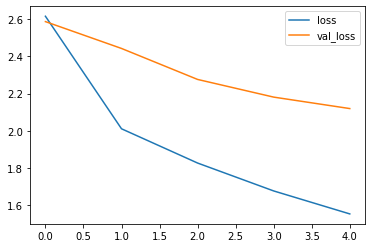

In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

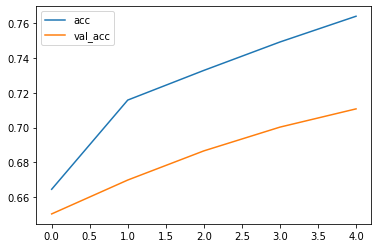

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

## Prediction

### Encoder

In [ ]:
##### Make predictions #####

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

### Decoder

In [ ]:
decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))

decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)

decoder_states = [h, c]

decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)


In [ ]:
# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<start>']

  # if we get this we break
  eos = word2idx_outputs['<end>']

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )

    # Get next word
    idx = np.argmax(output_tokens[0, 0, :])  

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]

  return ' '.join(output_sentence)

In [ ]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input: Tom rocks.
Translation: tom se quedó está de tom años.
Continue? [Y/n]Y
-
Input: Just leave it.
Translation: ahora lo nuevo.
Continue? [Y/n]n
